# Import libraries

In [1]:
from deeplcms_functions import convert_lcms_files, inspect_database, utils

# Testing

In [2]:
example_file = utils.Configuration.RAW_DATA_PATH.joinpath(
    "ST002432_IIV_Metformin/YW_20201206_047.mzML"
)

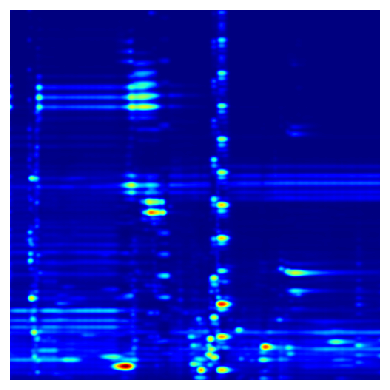

In [3]:
convert_lcms_files.plot_2D_spectra_overview(example_file, save=False)

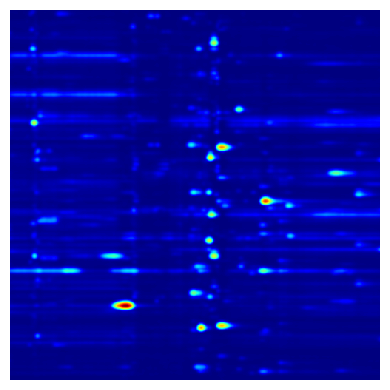

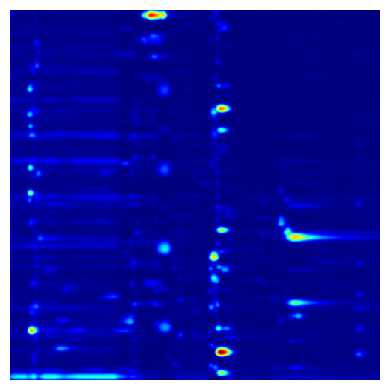

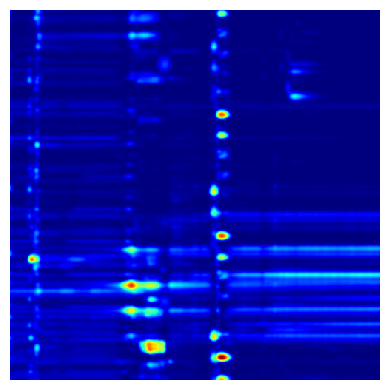

In [4]:
convert_lcms_files.plot_2D_spectra_slices(
    example_file, save=False, show=True, num_slices=3
)

# Define functions

In [174]:
def plot_spectra_2D_overview(file_location, gamma=0.5, num_colors=256, filter_size=2):
    """
    Generates a 2D overview plot of the mass spectra contained in a mzML file. Applies a logarithmic transformation
    and a median filter to the data, subtracts the background, and saves the resulting image as a JPEG file. The x-axis of the plot
    represents the retention time (RT) in seconds and the y-axis represents the mass-to-charge (m/z) values.

    Parameters:
    - file_location (str): the path to the mzML file to be analyzed.
    - gamma (float): gamma correction parameter for image contrast adjustment. Default is 0.5.
    - num_colors (int): the number of colors used to represent the intensity values. Default is 256.
    - filter_size (float): size of Gaussian filter for noise reduction. Default is 2.

    Returns:
    - None. The function generates a plot and saves it as a JPEG file.

    Note: This function requires the following external libraries: numpy, matplotlib, and scipy.

    Example usage:
    plot_spectra_2D_overview('/content/test_file.mzML')

    """

    exp = MSExperiment()
    MzMLFile().load(file_location, exp)

    rows = 300.0
    cols = 300.0
    exp.updateRanges()

    bilip = BilinearInterpolation()
    tmp = bilip.getData()
    tmp.resize(int(rows), int(cols), float())
    bilip.setData(tmp)
    bilip.setMapping_0(0.0, exp.getMinRT(), rows - 1, exp.getMaxRT())
    bilip.setMapping_1(0.0, exp.getMinMZ(), cols - 1, exp.getMaxMZ())
    for spec in exp:
        if spec.getMSLevel() == 1:
            mzs, ints = spec.get_peaks()
            rt = spec.getRT()
            for i in range(0, len(mzs)):
                bilip.addValue(rt, mzs[i], ints[i])

    data = np.ndarray(shape=(int(cols), int(rows)), dtype=np.float64)
    for i in range(int(rows)):
        for j in range(int(cols)):
            data[i][j] = bilip.getData().getValue(i, j)

    ms_map = np.power(data, gamma)

    # Represent intensity values with specified number of colors
    bins = np.linspace(0, np.max(ms_map), num_colors)
    ms_map = np.digitize(ms_map, bins)

    # Normalize intensity values using highest peak
    ms_map = ms_map / np.max(ms_map)

    # Apply Gaussian filter for noise reduction
    ms_map = ndimage.gaussian_filter(ms_map, sigma=filter_size)
    ms_map *= 255.0 / ms_map.max()

    # Display the normalized map using Matplotlib
    plt.imshow(np.rot90(ms_map), cmap="jet")
    plt.title("")
    plt.axis("off")
    plt.tight_layout()
    basename = os.path.splitext(file_location)[0]

    plt.savefig(f"{basename}.jpeg", bbox_inches="tight", pad_inches=0, dpi=300)


# plot_spectra_2D_overview("Positive_P9_T5.mzML")

In [6]:
# Directory to search in
dir_path = os.getcwd()

# Extension to filter by
extension = "*.mzML"

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    # Use glob to find files with the desired extension
    files_with_extension = glob.glob(os.path.join(root, extension))
    for file_path in files_with_extension:
        filename = os.path.basename(file_path)
        basename = os.path.splitext(filename)[0]
        print(filename)

YW_20201206_047.mzML


# Convert mzML to images

In [ ]:
# Directory to search in
dir_path = os.getcwd()

# Extension to filter by
extension = "*.mzML"

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    # Use glob to find files with the desired extension
    files_with_extension = glob.glob(os.path.join(root, extension))
    for file_path in files_with_extension:
        filename = os.path.basename(file_path)
        basename = os.path.splitext(filename)[0]

        print(f"Working on : {basename}")
        convert_lcms_files.plot_spectra_2D_overview(filename)
        print(f"{basename} is done")

Working on : YW_20201206_047


# Move datafiles to correct folders (according to which group they belong to)

In [ ]:
for_train_test_split = pd.DataFrame((pd.concat([CTR, DKO], axis=0))).assign(
    treated=lambda df: df.Sample_name.mask(df.Sample_name.isin(CTR), other=0).mask(
        df.Sample_name.isin(DKO), other=1
    )
)
for_train_test_split

,Sample_name,treated
0,N15_T20,0
1,NC10_T1,0
2,NC10_T10,0
3,NC10_T11,0
4,NC10_T12,0
...,...,...
454,P9_T5,1
455,P9_T6,1
456,P9_T7,1
457,P9_T8,1


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    for_train_test_split.Sample_name,
    for_train_test_split.treated,
    test_size=0.2,
    stratify=for_train_test_split.treated,
    random_state=42,
)

print(X_train.shape, X_val.shape)
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

(367,) (92,)
0    0.517711
1    0.482289
Name: treated, dtype: float64
0    0.521739
1    0.478261
Name: treated, dtype: float64


In [ ]:
# Directory to search in
dir_path = os.getcwd()

path_train = os.path.join(dir_path, "train")
path_train_CTR = os.path.join(dir_path, "train", "CTR")
path_train_DKO = os.path.join(dir_path, "train", "DKO")

path_val = os.path.join(dir_path, "val")
path_val_CTR = os.path.join(dir_path, "val", "CTR")
path_val_DKO = os.path.join(dir_path, "val", "DKO")


os.makedirs(path_train, exist_ok=True)
os.makedirs(path_train_CTR, exist_ok=True)
os.makedirs(path_train_DKO, exist_ok=True)


os.makedirs(path_val, exist_ok=True)
os.makedirs(path_val_CTR, exist_ok=True)
os.makedirs(path_val_DKO, exist_ok=True)

# Extension to filter by
extension = "*.jpeg"

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    # Use glob to find files with the desired extension
    files_with_extension = glob.glob(os.path.join(root, extension))
    for file_path in files_with_extension:
        filename = os.path.basename(file_path)
        basename = os.path.splitext(filename)[0]

        print(basename)

        if X_train.isin([basename]).any():
            if CTR.isin([basename]).any():
                shutil.copy(os.path.join(dir_path, filename), path_train_CTR)
            else:
                shutil.copy(os.path.join(dir_path, filename), path_train_DKO)

        if X_val.isin([basename]).any():
            if CTR.isin([basename]).any():
                shutil.copy(os.path.join(dir_path, filename), path_val_CTR)
            else:
                shutil.copy(os.path.join(dir_path, filename), path_val_DKO)